In [1]:
import cv2
import torch
import time

from mmdet.apis import show_result_pyplot
from mmdet.apis import  init_detector
from mmdet.apis import inference_detector

from mmpose.apis import init_pose_model
from mmpose.apis import vis_pose_result
from mmpose.apis import inference_bottom_up_pose_model
from mmpose.apis import inference_top_down_pose_model

%matplotlib inline
import matplotlib.pyplot as plt

# Read Image

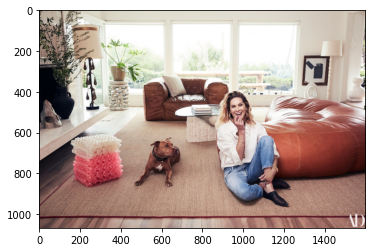

In [2]:
img = cv2.imread('../../../data/images/example2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);


In [3]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding autoShape... 
YOLOv5 🚀 2021-5-11 torch 1.8.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3080, 10240.0MB)



In [4]:
def process_yolo(results, score_thr):
    bboxes_all = results.xyxy[0].detach().cpu().numpy()
    bboxes_person = bboxes_all[bboxes_all[:, -1] == 0]
    bboxes_select = bboxes_person[bboxes_person[:, -2] > score_thr]
    bboxes_select = bboxes_select[:, :-1]
    person_results = []
    
    for bbox in bboxes_select:
        person = {}
        person['bbox'] = bbox
        person_results.append(person)

    return person_results

In [5]:
det_results = yolo_model(img)

person_results = process_yolo(det_results, score_thr=0.3)

In [6]:
topdown_config = '../../../configs/pose/top_down/mobilenet_v2/coco/mobilenetv2_coco_256x192.py'
topdown_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/mobilenetv2/mobilenetv2_coco_256x192-d1e58e7b_20200727.pth'

pose_model = init_pose_model(
    config=topdown_config,
    checkpoint=topdown_checkpoint,
    device='cuda:0'
)

Use load_from_http loader


In [7]:
pose_results,_ = inference_top_down_pose_model(
                                    model=pose_model,
                                    img_or_path=img,
                                    person_results=person_results,
                                    format='xyxy'
)

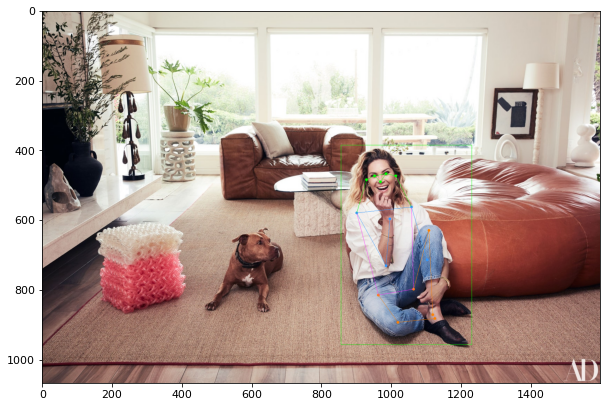

In [8]:
vis_result = vis_pose_result(
                model=pose_model,
                img=img,
                result=pose_results,
)

plt.figure(figsize=(10, 10))
plt.imshow(vis_result);

# Inference on video

In [12]:
import time

torch.backends.cudnn.benchmark = True

video_path = '../../../data/videos/example1.mp4'
out_video_path = '../../../data/visual_results/example1.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

print(fps, size)

29.97002997002997 (854, 480)


In [13]:
FONT_SCALE = 0.5
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_COLOR = (39, 0, 247)
FONT_THICKNESS = 2

In [14]:
while (cap.isOpened()):
    flag, img = cap.read()
    if not flag:
        break
    s1 = time.time()

    # test a single image, the resulting box is (x1, y1, x2, y2)
    yolo_results = yolo_model(img)
    time_yolo = time.time()-s1

    #  preprocess yolov5 bounding boxes.
    person_results = process_yolo(yolo_results, score_thr=0.3)
    
    s2 = time.time()
    if len(person_results) == 0: # skipping pose model if there aren't any person in frame
        vis_img = img
        time_pose = time.time() - s2
    else:
        pose_results, _ = inference_top_down_pose_model(
                            model=pose_model,
                            img_or_path=img,
                            person_results=person_results,
                            format='xyxy'
        )
        time_pose = time.time() - s2

        # show the results
        vis_img = vis_pose_result(
                    pose_model,
                    img,
                    pose_results,
                    kpt_score_thr=0.3,
                    show=False
        )
    fps_process = 1 / (time.time()-s1)
    
    cv2.putText(vis_img,f'FPS {fps_process:.2f}', (15, 30),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    
    cv2.putText(vis_img,f'Detection {1/time_yolo:.2f}', (15, 55),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    cv2.putText(vis_img,f'Pose {1/time_pose:.2f}', (15, 80),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    
    cv2.imshow('Image', vis_img)
    
    if cv2.waitKey(0) == ord('k'):
        break

cap.release()
cv2.destroyAllWindows()

107
113
